# Fibroblast gene Repression Analysis vs AP1 Binding in Transient peaks

Examine repression of fibroblast genes in High and Low OSK clusters vs accessibility at new sites with AP1 motifs.

In [1]:
library(Seurat)
library(ggplot2)
library(patchwork)
library(scales)
library(Matrix)
library(GenomicRanges)
library(dplyr)
library(rtracklayer)
library(matrixStats)
library(ggforce)

Loading required package: stats4

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following object is masked from ‘package:Matrix’:

    which


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which, which.max, which.min


Loading

## Load Data

In [2]:
rna = readRDS("../../analysis/20220606_Multiome_RNA_Seurat/sessions/20220608_n7378/seurat.rds")

In [3]:
# Metadata file for scATAC + Multiome ATAC
atac_metaData = read.table("../../analysis/20220609_Multiome_SnapATAC/sessions/20220612_n13525/metadata.w.transfer.cluster.tsv", header = T, stringsAsFactor=F)
# atac_metaData = read.table("../20220609_Multiome_SnapATAC/metadata.no.harmony.tsv", header = T, stringsAsFactor=F)
rownames(atac_metaData) = paste(atac_metaData$sample, atac_metaData$barcode, sep='_')
atac_metaData$cells = rownames(atac_metaData)
dim(atac_metaData)
head(atac_metaData, 5)

[1] 13525    12

,barcode,TN,UM,PP,UQ,CM,cluster,umap1,umap2,sample,cells,transfered_cluster
,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<chr>,<chr>,<int>
D1M_AAAAAAAAAAACATGCTATTAGCC,AAAAAAAAAAACATGCTATTAGCC,6736,6736,6736,6729,373,3,-0.4031222,-3.454888,D1M,D1M_AAAAAAAAAAACATGCTATTAGCC,3
D1M_AAAAAAAAAAACATGCTCACCCTC,AAAAAAAAAAACATGCTCACCCTC,28369,28369,28369,28339,2447,5,2.6643078,-3.955240,D1M,D1M_AAAAAAAAAAACATGCTCACCCTC,3
D1M_AAAAAAAAAAACATGCTTGAGAAC,AAAAAAAAAAACATGCTTGAGAAC,28635,28635,28635,28609,2201,1,-0.2071755,2.688192,D1M,D1M_AAAAAAAAAAACATGCTTGAGAAC,15
D1M_AAAAAAAAAAACCATGAACCTTGT,AAAAAAAAAAACCATGAACCTTGT,33869,33869,33869,33838,3018,5,3.1269215,-4.609105,D1M,D1M_AAAAAAAAAAACCATGAACCTTGT,3
D1M_AAAAAAAAAAACCATGAGCTTAAA,AAAAAAAAAAACCATGAGCTTAAA,18885,18885,18885,18867,1514,1,-0.1988264,1.998739,D1M,D1M_AAAAAAAAAAACCATGAGCTTAAA,15


In [4]:
atac_metaData_multiome_filt = atac_metaData[atac_metaData$sample!="D2", ]
dim(atac_metaData_multiome_filt)

[1] 7378   12

In [7]:
atac_to_rna_bc_map = read.table("/oak/stanford/groups/akundaje/surag/projects/scMultiome-reprog/ATAC.RNA.bc.map.tsv", sep='\t', 
                                header=F, stringsAsFactors=F)
colnames(atac_to_rna_bc_map) = c("ATAC", "RNA")
rownames(atac_to_rna_bc_map) = paste("AAAAAAAA", atac_to_rna_bc_map$ATAC, sep='')
head(atac_to_rna_bc_map)

,ATAC,RNA
,<chr>,<chr>
AAAAAAAAGTAACACACCCGCTGT,GTAACACACCCGCTGT,AAACAGCCAAACAACA
AAAAAAAAAAGAACAACCCGCTGT,AAGAACAACCCGCTGT,AAACAGCCAAACATAG
AAAAAAAAGCCTGTTACCCGCTGT,GCCTGTTACCCGCTGT,AAACAGCCAAACCCTA
AAAAAAAATTCGCGCACCCGCTGT,TTCGCGCACCCGCTGT,AAACAGCCAAACCTAT
AAAAAAAAATGGAGGACCCGCTGT,ATGGAGGACCCGCTGT,AAACAGCCAAACCTTG
AAAAAAAAAACCATGACCCGCTGT,AACCATGACCCGCTGT,AAACAGCCAAACGCGA


In [8]:
all(atac_metaData_multiome_filt$barcode %in% rownames(atac_to_rna_bc_map))

[1] TRUE

In [9]:
head(atac_metaData_multiome_filt)

,barcode,TN,UM,PP,UQ,CM,cluster,umap1,umap2,sample,cells,transfered_cluster
,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<chr>,<chr>,<int>
D1M_AAAAAAAAAAACATGCTATTAGCC,AAAAAAAAAAACATGCTATTAGCC,6736,6736,6736,6729,373,3,-0.4031222,-3.454888,D1M,D1M_AAAAAAAAAAACATGCTATTAGCC,3
D1M_AAAAAAAAAAACATGCTCACCCTC,AAAAAAAAAAACATGCTCACCCTC,28369,28369,28369,28339,2447,5,2.6643078,-3.955240,D1M,D1M_AAAAAAAAAAACATGCTCACCCTC,3
D1M_AAAAAAAAAAACATGCTTGAGAAC,AAAAAAAAAAACATGCTTGAGAAC,28635,28635,28635,28609,2201,1,-0.2071755,2.688192,D1M,D1M_AAAAAAAAAAACATGCTTGAGAAC,15
D1M_AAAAAAAAAAACCATGAACCTTGT,AAAAAAAAAAACCATGAACCTTGT,33869,33869,33869,33838,3018,5,3.1269215,-4.609105,D1M,D1M_AAAAAAAAAAACCATGAACCTTGT,3
D1M_AAAAAAAAAAACCATGAGCTTAAA,AAAAAAAAAAACCATGAGCTTAAA,18885,18885,18885,18867,1514,1,-0.1988264,1.998739,D1M,D1M_AAAAAAAAAAACCATGAGCTTAAA,15
D1M_AAAAAAAAAAACCATGATATAGGC,AAAAAAAAAAACCATGATATAGGC,12385,12385,12385,12370,1282,5,1.7942727,-3.712197,D1M,D1M_AAAAAAAAAAACCATGATATAGGC,3


In [10]:
rna_bc_order = paste(atac_to_rna_bc_map[atac_metaData_multiome_filt$barcode, "RNA"], ifelse(atac_metaData_multiome_filt$sample=="D1M", 1, 2), sep='-')
head(rna_bc_order)

[1] "CAAACCGTCCAATAGC-1" "TACTTCGTCCAATAGC-1" "TTTGTGTTCCAATAGC-1"
[4] "CTCTCACAGATAAAGC-1" "GGCCTTAAGATAAAGC-1" "CCAAGTTAGATAAAGC-1"

In [11]:
all(rna_bc_order %in% colnames(rna))

[1] TRUE

In [12]:
# fibr_genes = as.character(unlist(read.table("../20200828_RNA_Seurat/lists/fibroblast.genes.txt")$V1))
# fibr_genes = fibr_genes[fibr_genes %in% rownames(rna)]
# length(fibr_genes)

In [13]:
fibr_genes = as.character(unlist(read.table("../../analysis/20220612_Multiome_Repression/fibr_ipsc_diff.txt")$V1))
length(fibr_genes)
fibr_genes = fibr_genes[fibr_genes %in% rownames(rna)]
length(fibr_genes)

[1] 1113

[1] 1113

In [14]:
cluster_config = read.table("../../figures_factory/configs/cluster.tsv", comment.char = '', sep='\t', header=T)
cluster_config$label = paste(cluster_config$new_cluster, cluster_config$description, sep=' - ')
cluster_config

cluster,colour,description,new_cluster,label
<int>,<fct>,<fct>,<int>,<chr>
1,#B03743,Fibroblast,1,1 - Fibroblast
2,#E85F6D,Fibroblast-like,3,3 - Fibroblast-like
3,#7C2730,Fibroblast-like,2,2 - Fibroblast-like
4,#F0A118,Intermediate,12,12 - Intermediate
5,#78A824,Pre-iPSC,13,13 - Pre-iPSC
6,#A6D854,Pre-iPSC,14,14 - Pre-iPSC
7,#F01D35,Fibroblast-like,5,5 - Fibroblast-like
8,#13C4A3,iPSC,15,15 - iPSC
9,#406614,Partially-reprogrammed,10,10 - Partially-reprogrammed


In [15]:
day_config = read.table("../configs/multiome_day.tsv", comment.char = '', header=T)
day_config$colour = as.character(day_config$colour)
day_config$day = factor(day_config$day, levels=c("D1M", "D2M", "D2"))
rownames(day_config) = day_config$day
day_config

,day,colour
,<fct>,<chr>
D1M,D1M,#53a548
D2M,D2M,#6E3B4E
D2,D2,#FF70A6


In [16]:
atac_pmat = readMM("../../analysis/20220609_Multiome_SnapATAC/sessions/20220612_n13525/pmat.sparse.mm")

In [17]:
atac_peaks = read.table("../../analysis/20220609_Multiome_SnapATAC/sessions/20220612_n13525/peaks.bed")
colnames(atac_peaks) = c("chr", "start", "end")
atac_peaks = GRanges(atac_peaks)

In [18]:
# AP1 hits in D2 High OSK peaks that are not fibrobalst peaks
ap1_not_fibr_hits = read.table("./AP1.not.fibr.bed", sep='\t', header=F)
ap1_not_fibr_hits = ap1_not_fibr_hits[, 1:3]
colnames(ap1_not_fibr_hits) = c("chr","start","end")
ap1_not_fibr_hits = GRanges(ap1_not_fibr_hits)
ap1_not_fibr_hits                           

GRanges object with 10773 ranges and 0 metadata columns:
          seqnames            ranges strand
             <Rle>         <IRanges>  <Rle>
      [1]    chr17 46474674-46474683      *
      [2]    chr17 70057186-70057195      *
      [3]    chr17 19642881-19642890      *
      [4]    chr13 32056511-32056520      *
      [5]    chr13 58087773-58087782      *
      ...      ...               ...    ...
  [10769]     chrY 15405628-15405637      *
  [10770]     chrY   7858109-7858118      *
  [10771]     chrY 12833476-12833485      *
  [10772]     chrY 13218725-13218734      *
  [10773]     chrY   7588374-7588383      *
  -------
  seqinfo: 24 sequences from an unspecified genome; no seqlengths

In [19]:
# AP1 hits in fibroblast peaks
ap1_fibr_hits = read.table("./AP1.fibr.bed", sep='\t', header=F)
ap1_fibr_hits = ap1_fibr_hits[, 1:3]
colnames(ap1_fibr_hits) = c("chr","start","end")
ap1_fibr_hits = GRanges(ap1_fibr_hits)
ap1_fibr_hits                           

GRanges object with 69064 ranges and 0 metadata columns:
          seqnames            ranges strand
             <Rle>         <IRanges>  <Rle>
      [1]     chr1       38706-38718      *
      [2]     chr1     144027-144039      *
      [3]     chr1     178814-178826      *
      [4]     chr1     203620-203632      *
      [5]     chr1     281636-281648      *
      ...      ...               ...    ...
  [69060]     chrY 24270858-24270870      *
  [69061]     chrY 24363865-24363877      *
  [69062]     chrY 25306260-25306272      *
  [69063]     chrY 25399276-25399288      *
  [69064]     chrY 26670841-26670853      *
  -------
  seqinfo: 24 sequences from an unspecified genome; no seqlengths

## Expression Plots

In [20]:
get_plot <- function(gene, selection=NULL, min_quant=0.02) {
    cur_gene = as.vector(rna[['RNA']][gene, rna_bc_order])
    
    plot_vals(cur_gene, selection, min_quant) + ggtitle(sub("-2[0-9]+", "",gene)) 
}

plot_vals <- function(vals, selection=NULL, min_quant=0.02) {
    
    if (is.null(selection)) {
        selection = seq(length(vals))
    }
    df = data.frame(umap1=atac_metaData_multiome_filt$umap1[selection], 
                    umap2=atac_metaData_multiome_filt$umap2[selection],
                    expr=vals[selection])
    # shuffle so days don't overlap
    df = df[sample(dim(df)[1]), ]


    expr_plot <- ggplot(df) +
    # ggplot(df[df$x.sp.sample %in% c("D14"), ]) +
    geom_point(size=.8, aes(x=umap1 , y=umap2, col=expr)) +
    scale_color_viridis_c(option = "C", name="Log2\nExpr", 
                         limits=c(quantile(vals, min_quant),quantile(vals, 0.98)), oob=squish) +
    theme_classic() +
        xlab("UMAP 1") + ylab("UMAP 2") +
        theme(plot.title = element_text(hjust = 0.5),
              text = element_text(size=12),
              axis.line=element_blank(),
              axis.text.x=element_blank(),
              axis.text.y=element_blank(),
              axis.ticks=element_blank(),
              panel.border = element_rect(colour = "black", fill=NA, size=0.5)) +
        coord_fixed()    
    
    expr_plot
}

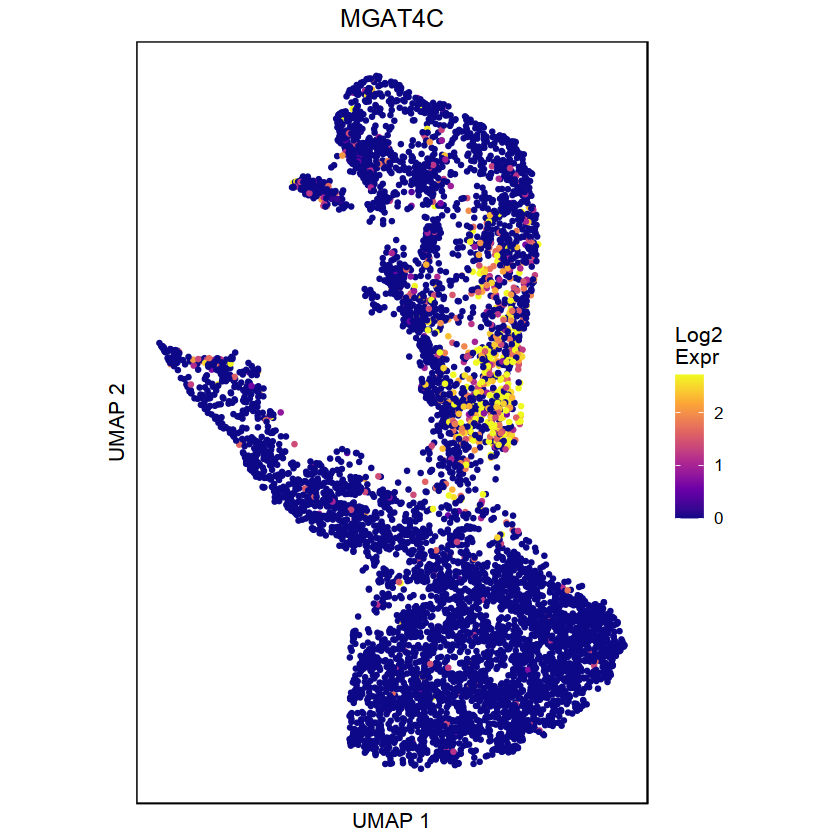

In [21]:
options(repr.plot.width = 7, repr.plot.height = 7)

get_plot("MGAT4C")

In [27]:
mean_fibr_scaled = as.vector(colMeans(rna@assays$RNA@scale.data[fibr_genes, rna_bc_order]))
mean(mean_fibr_scaled[(atac_metaData_multiome_filt$sample=="D2M")&(atac_metaData_multiome_filt$transfered_cluster==11)])
mean(mean_fibr_scaled[(atac_metaData_multiome_filt$sample=="D2M")&(atac_metaData_multiome_filt$transfered_cluster==15)])
mean(mean_fibr_scaled[(atac_metaData_multiome_filt$sample=="D2M")&(atac_metaData_multiome_filt$transfered_cluster==13)])
mean(mean_fibr_scaled[(atac_metaData_multiome_filt$sample=="D2M")&(atac_metaData_multiome_filt$transfered_cluster==3)])

[1] -0.07650123

[1] -0.05975318

[1] 0.009800309

[1] 0.04655874

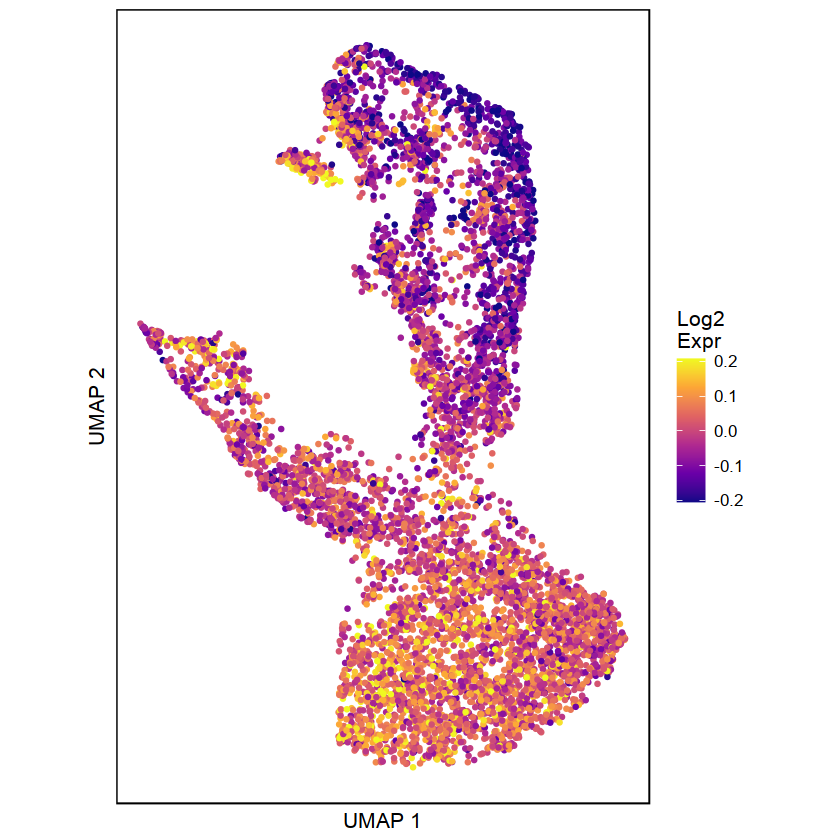

In [22]:
options(repr.plot.width = 7, repr.plot.height = 7)
plot_vals(mean_fibr_scaled) #, selection=atac_metaData_multiome_filt$sample=="D2M")

In [23]:
pmat_rsums = Matrix::rowSums(atac_pmat)

In [23]:
reads_in_ap1_not_fibr_peaks_pmat = Matrix::rowSums(atac_pmat[, unique(queryHits(findOverlaps(atac_peaks, ap1_not_fibr_hits)))])

In [24]:
reads_in_ap1_fibr_peaks_pmat = Matrix::rowSums(atac_pmat[, unique(queryHits(findOverlaps(atac_peaks, ap1_fibr_hits)))])

In [25]:
cor(reads_in_ap1_fibr_peaks_pmat/pmat_rsums, reads_in_ap1_not_fibr_peaks_pmat/pmat_rsums, method='spearman')

[1] -0.7151345

## Sequestration plots

In [133]:
make_sequestration_plot <- function(atac_score, expr_score, clusters) {
    plot_df = data.frame(x=atac_score, 
                  y=expr_score,
                c=factor(clusters))
    # shuffle
    plot_df = plot_df[sample(nrow(plot_df)), ]
    
    config_subset = cluster_config[cluster_config$cluster %in% as.integer(clusters),]

    p = ggplot(plot_df,
          aes(x=x, y=y,color=c)) +
    scale_color_manual(values=as.character(config_subset$colour), 
                   labels=as.character(config_subset$description),
                  name="Cell state") +
    geom_point(size=1) + 
    geom_smooth(method = "lm", se = FALSE, color='red',size=1.5) + 
    xlab("Normalized reads in non-fibroblast peaks with AP1 sites") + 
    ylab("Fibroblast-specific genes Z-score") +
    theme_bw(base_size=18)  + 
    theme(                  panel.grid.major = element_blank()
    #                   panel.grid.minor = element_blank()
    )

    p
}


### D2, hOSK and xOSK

In [111]:
selection = (atac_metaData_multiome_filt$sample %in% c("D2M"))&(atac_metaData_multiome_filt$transfered_cluster%in% c(11,15))

d2m_osk_frac_reads_in_ap1_not_fibr = (reads_in_ap1_not_fibr_peaks_pmat/pmat_rsums)[atac_metaData$sample!="D2"][selection]
d2m_osk_mean_fibr_scaled = mean_fibr_scaled[selection]

cor(d2m_osk_frac_reads_in_ap1_not_fibr, d2m_osk_mean_fibr_scaled, method='spearman')

[1] -0.5435617

In [112]:
cor.test(d2m_osk_frac_reads_in_ap1_not_fibr, d2m_osk_mean_fibr_scaled, method='spearman')

Warning message in cor.test.default(d2m_osk_frac_reads_in_ap1_not_fibr, d2m_osk_mean_fibr_scaled, :
“Cannot compute exact p-value with ties”



	Spearman's rank correlation rho

data:  d2m_osk_frac_reads_in_ap1_not_fibr and d2m_osk_mean_fibr_scaled
S = 954301133, p-value < 2.2e-16
alternative hypothesis: true rho is not equal to 0
sample estimates:
       rho 
-0.5435617 


`geom_smooth()` using formula 'y ~ x'



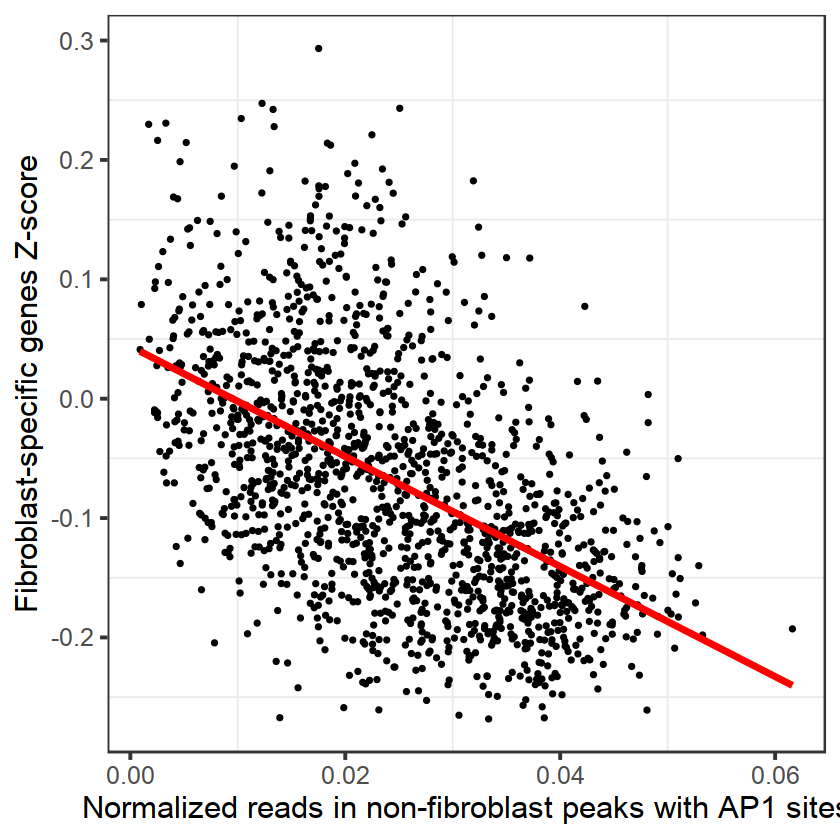

In [35]:
options(repr.plot.width = 7, repr.plot.height = 7)

p = ggplot(data.frame(x=d2m_osk_frac_reads_in_ap1_not_fibr, 
                  y=d2m_osk_mean_fibr_scaled),
      aes(x=x, y=y)) +
geom_point(size=1) + 
geom_smooth(method = "lm", se = FALSE, color='red',size=1.5) + 
xlab("Normalized reads in non-fibroblast peaks with AP1 sites") + 
ylab("Fibroblast-specific genes Z-score") +
theme_bw(base_size=18)  + 
theme(                  panel.grid.major = element_blank()
#                   panel.grid.minor = element_blank()
)

p

In [51]:
ggsave("./subfigs/TransAP1vsFibrExpr_D2.pdf", p, height=7, width=7, useDingbats=F)

`geom_smooth()` using formula 'y ~ x'



### D1, hOSK and xOSK

In [177]:
selection = (atac_metaData_multiome_filt$sample %in% c("D1M"))&(atac_metaData_multiome_filt$transfered_cluster%in% c(11,15))

d1m_osk_frac_reads_in_ap1_not_fibr = (reads_in_ap1_not_fibr_peaks_pmat/pmat_rsums)[atac_metaData$sample!="D2"][selection]
d1m_osk_mean_fibr_scaled = mean_fibr_scaled[selection]

cor(d1m_osk_frac_reads_in_ap1_not_fibr, d1m_osk_mean_fibr_scaled, method='spearman')

[1] -0.5233908

In [178]:
cor.test(d1m_osk_frac_reads_in_ap1_not_fibr, d1m_osk_mean_fibr_scaled, method='spearman')

Warning message in cor.test.default(d1m_osk_frac_reads_in_ap1_not_fibr, d1m_osk_mean_fibr_scaled, :
“Cannot compute exact p-value with ties”



	Spearman's rank correlation rho

data:  d1m_osk_frac_reads_in_ap1_not_fibr and d1m_osk_mean_fibr_scaled
S = 473624268, p-value < 2.2e-16
alternative hypothesis: true rho is not equal to 0
sample estimates:
       rho 
-0.5233908 


`geom_smooth()` using formula 'y ~ x'



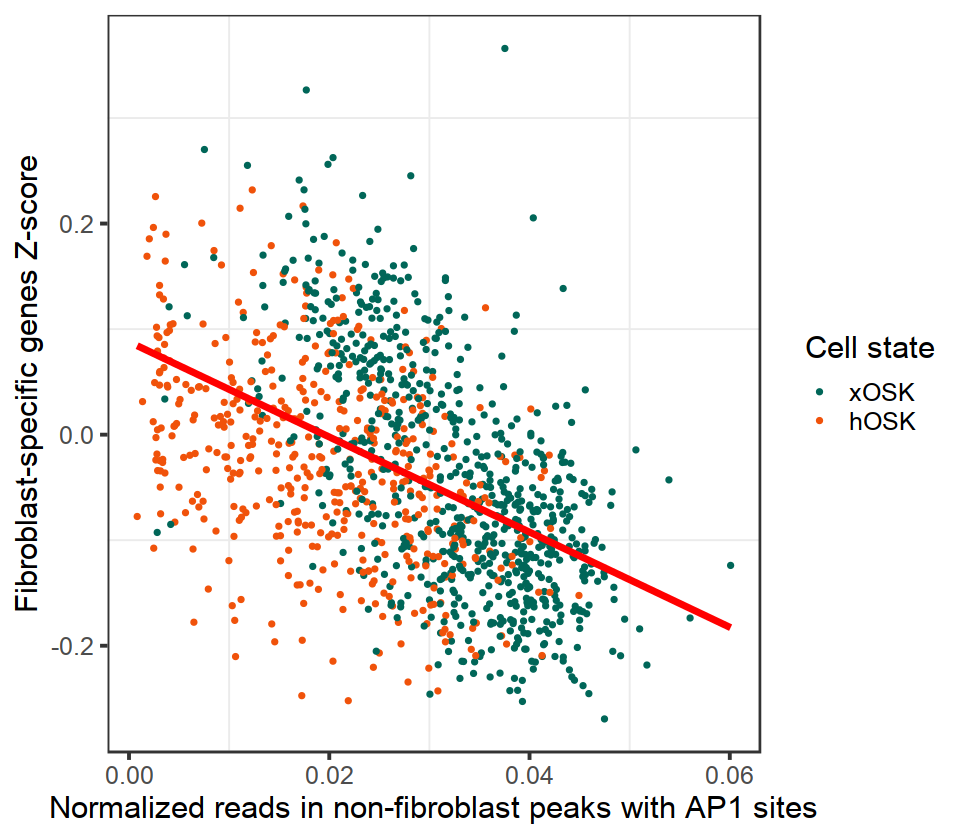

In [179]:
options(repr.plot.width = 8, repr.plot.height = 7)

p = make_sequestration_plot(d1m_osk_frac_reads_in_ap1_not_fibr, 
                        d1m_osk_mean_fibr_scaled, 
                        atac_metaData_multiome_filt[selection, "transfered_cluster"])

p

In [180]:
ggsave("./subfigs/TransAP1vsFibrExpr_D1.pdf", p, height=7, width=8, useDingbats=F)

`geom_smooth()` using formula 'y ~ x'



### D2, All except Ker

In [206]:
selection = (atac_metaData_multiome_filt$sample %in% c("D2M"))&(atac_metaData_multiome_filt$transfered_cluster%in% c(11,15,2,3))

d2m_non_ker_frac_reads_in_ap1_not_fibr = (reads_in_ap1_not_fibr_peaks_pmat/pmat_rsums)[atac_metaData$sample!="D2"][selection]
d2m_non_ker_mean_fibr_scaled = mean_fibr_scaled[selection]

cor(d2m_non_ker_frac_reads_in_ap1_not_fibr, d2m_non_ker_mean_fibr_scaled, method='spearman')

[1] -0.5733559

In [207]:
cor.test(d2m_non_ker_frac_reads_in_ap1_not_fibr, d2m_non_ker_mean_fibr_scaled, method='spearman')

Warning message in cor.test.default(d2m_non_ker_frac_reads_in_ap1_not_fibr, d2m_non_ker_mean_fibr_scaled, :
“Cannot compute exact p-value with ties”



	Spearman's rank correlation rho

data:  d2m_non_ker_frac_reads_in_ap1_not_fibr and d2m_non_ker_mean_fibr_scaled
S = 9744157402, p-value < 2.2e-16
alternative hypothesis: true rho is not equal to 0
sample estimates:
       rho 
-0.5733559 


`geom_smooth()` using formula 'y ~ x'



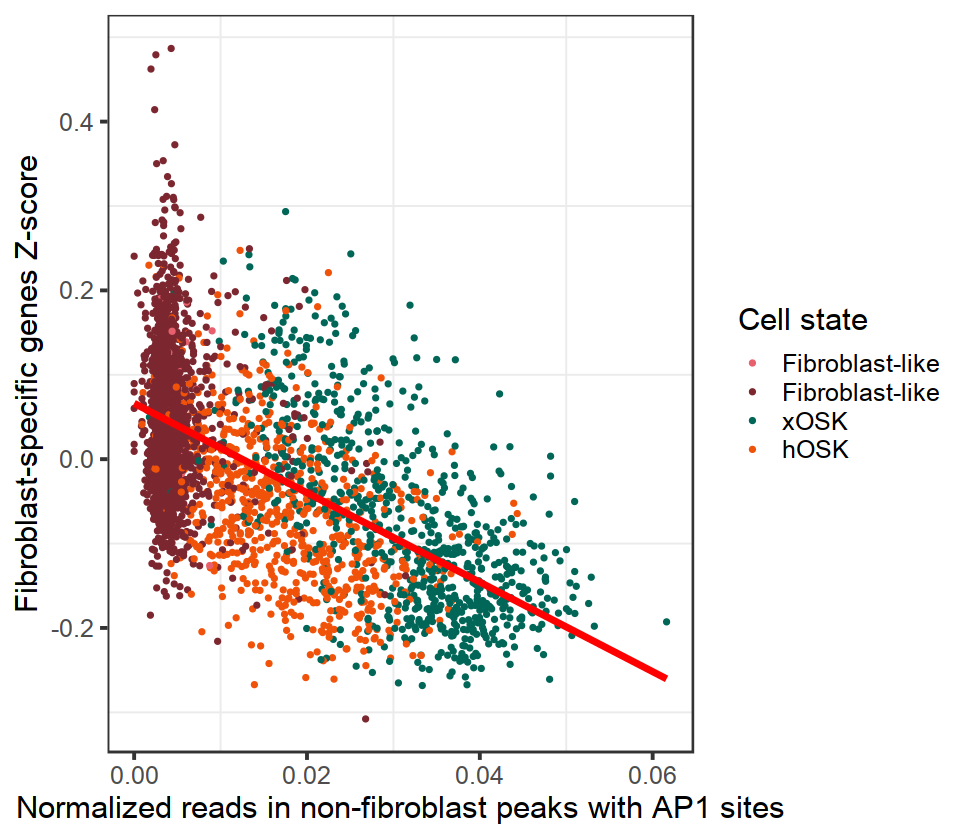

In [208]:
p = make_sequestration_plot(d2m_non_ker_frac_reads_in_ap1_not_fibr, 
                        d2m_non_ker_mean_fibr_scaled, 
                        atac_metaData_multiome_filt[selection, "transfered_cluster"])

p

In [184]:
ggsave("./subfigs/TransAP1vsFibrExpr_D2_with_fibrlike.pdf", p, height=7, width=8, useDingbats=F)

`geom_smooth()` using formula 'y ~ x'



### D2, hOSK and xOSK [AP1 fibr sites]

In [198]:
selection = (atac_metaData_multiome_filt$sample %in% c("D2M"))&(atac_metaData_multiome_filt$transfered_cluster%in% c(11,15))

d2m_osk_frac_reads_in_ap1_fibr = (reads_in_ap1_fibr_peaks_pmat/pmat_rsums)[atac_metaData$sample!="D2"][selection]
d2m_osk_mean_fibr_scaled = mean_fibr_scaled[selection]

cor(d2m_osk_frac_reads_in_ap1_fibr, d2m_osk_mean_fibr_scaled, method='spearman')

[1] 0.5949162

In [199]:
cor.test(d2m_osk_frac_reads_in_ap1_fibr, d2m_osk_mean_fibr_scaled, method='spearman')


	Spearman's rank correlation rho

data:  d2m_osk_frac_reads_in_ap1_fibr and d2m_osk_mean_fibr_scaled
S = 250441526, p-value < 2.2e-16
alternative hypothesis: true rho is not equal to 0
sample estimates:
      rho 
0.5949162 


`geom_smooth()` using formula 'y ~ x'



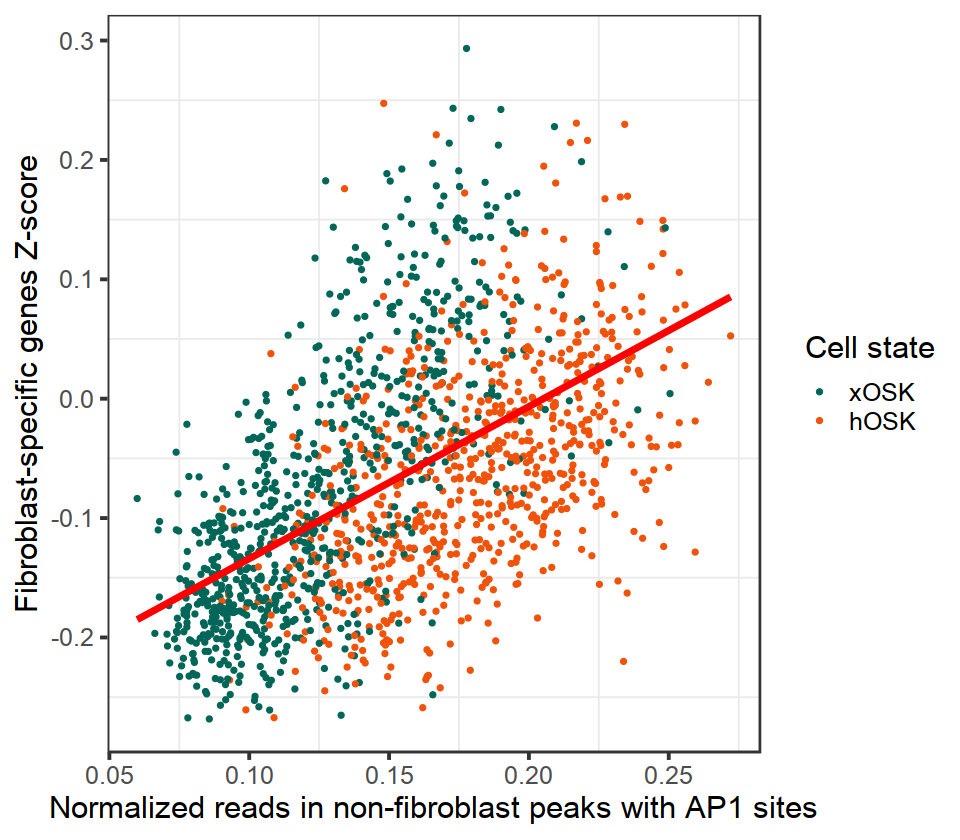

In [200]:
p = make_sequestration_plot(d2m_osk_frac_reads_in_ap1_fibr, 
                        d2m_osk_mean_fibr_scaled, 
                        atac_metaData_multiome_filt[selection, "transfered_cluster"])
p

In [188]:
ggsave("./subfigs/FibrAP1vsFibrExpr_D2.pdf", p, height=7, width=8, useDingbats=F)

`geom_smooth()` using formula 'y ~ x'



---

In [213]:
sessionInfo()

R version 3.6.3 (2020-02-29)
Platform: x86_64-conda_cos6-linux-gnu (64-bit)
Running under: Ubuntu 18.04.6 LTS

Matrix products: default
BLAS/LAPACK: /users/surag/anaconda3/envs/r36_cran/lib/libopenblasp-r0.3.9.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] parallel  stats4    stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] ggforce_0.3.2        matrixStats_0.56.0   rtracklayer_1.46.0  
 [4] dplyr_1.0.2          GenomicRanges_1.38.0 GenomeInfoDb_1.22.1 
 [7] IRanges_2.20.2       S4Vectors_0.24.4     BiocGenerics_0.32.0 
[10] Matrix_1.2-18        scales_1.1.0         patchwork_1.0.0     
[13